In [11]:
from IPython.display import display, clear_output
from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
import psycopg2
import datetime
import os
import seaborn as sns
import pandas as pd
import numpy as np
import requests
import random
import time
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import gmplot
from geopy.geocoders import Nominatim
from cheese_utils import (
    RawCheese, get_all_cheeses_url_names, get_cheeses_url_names,
    ingredients, split_columns
)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances
from sklearn.feature_extraction.text import CountVectorizer

%matplotlib inline

In [100]:
class RawCheesesDF:
    def __init__(self,all_cheeses_url_names=None,from_file=True,delay=0.1):
        if from_file and os.path.exists("raw_cheeses.csv"):
            self.raw_df = pd.read_csv("raw_cheeses.csv",index_col=0)
        else:
            columns = ["name"]
            self.raw_df = pd.DataFrame(columns=columns)
            self.raw_df.set_index("name")
            for cheese_url in all_cheeses_url_names:
                clear_output(wait=True)
                display("getting cheese {}".format(cheese_url))
                raw_cheese = RawCheese(cheese_url)
                time.sleep(delay)
                self.raw_df = self.raw_df.append(raw_cheese.dict, ignore_index=True)
        self.cooked_df = None
        for split_column in split_columns:
            setattr(self, split_column, None)
        self.docs = None
    
    def simple_tokenizer(self,sentence):
        remove_list = ["'s","milk"]
        sep_list = [" and "," or "]
        for pattern in remove_list:
            sentence = sentence.replace(pattern,"")
        for pattern in sep_list:
            sentence = sentence.replace(pattern,",")
        sentence = sentence.replace(" ",",")
        return [word.strip() for word in sentence.split(",") if len(word)>1]
    
    def column_parser(self,str_instance):
        return [item.strip().lower() for item in str_instance.replace(" and ",",").split(',')]  
        
    def get_split_column(self,column):
        """
            find the names of new columns to be added to self.cooked_df for each column "column" by parsing all the rows
            for that column and finding all the unique keywords
        """
        if getattr(self,column)==None:
            if column=='ingredients':
                return ingredients
            else:
                columns = set()
                for row_str in self.raw_df[column][self.raw_df[column].notnull()]:
                    items = self.column_parser(row_str)#[item.strip().lower() for item in row_str.replace(" and ",",").split(',')]               
                    columns.update(items)
                setattr(self, column, columns)    
                return columns
        else:
            return getattr(self,column)
    
    @property
    def split_columns_dict(self):
        """
            for each initial column name create a dict with key the column name and values the split string
        """
        split_columns_dict = dict.fromkeys(split_columns,[])
        for column in split_columns: 
            split_columns_dict[column] = self.get_split_column(column)
        return split_columns_dict
    
    @property
    def cooked_columns(self):
        """
            collect all the sub-columns or 'cooked' columns into a set
        """
        old_columns = set(self.raw_df.keys()).difference(set(self.split_columns_dict.keys()))
        new_columns = set()
        for x in self.split_columns_dict.values():
            new_columns.update(set(x))
        return old_columns.union(new_columns)

    def get_docs(self):
        """
           pool descriptor from all relevant columns and store them as a string in a dict
        """
        if self.docs==None:
            docs = dict.fromkeys(list(self.raw_df['name']),'')
            pooled_df = self.raw_df.filter(split_columns, axis=1)
            for ix in range(len(pooled_df)):
                docs[self.raw_df['name'][ix]] = self.simple_tokenizer(pooled_df.iloc[ix,:].str.cat(sep=", "))
            self.docs=docs
        return self.docs

    def get_fitted_tfidf(self): 
        tfidf = TfidfVectorizer(
        analyzer='word',
        tokenizer=lambda x : x,
        preprocessor=lambda x : x,
        token_pattern=None)
        tfidf.fit(list(self.get_docs().values()))
        return tfidf
    
    def get_fitted_cntvect(self): 
        cntvect = CountVectorizer(
        analyzer='word',
        tokenizer=lambda x : x,
        preprocessor=lambda x : x,
        token_pattern=None)
        cntvect.fit(list(self.get_docs().values()))
        return cntvect
    
    def get_cosine_similarity_matrix(
            self,
            feature_extractor='default',
            mean_similarity_thresh=0.1,
            min_description_len=7,
            with_distplot=True,
        ):
        if feature_extractor in ['default','TfidfVectorizer']:
            f_extrct = self.get_fitted_tfidf()
        elif feature_extractor=='CountVectorizer':
            f_extrct = self.get_fitted_cntvect()
        else:
            raise ValueError('blabla')
        features_matrix = f_extrct.fit_transform(list(self.docs.values()))
        cosine = cosine_similarity(features_matrix)
        print(cosine.shape)
        # average similarity threshold 
        mean_sim_vec = np.mean(cosine,axis=0)
        friendly_cheeses_indexes = np.argwhere(mean_sim_vec>=mean_similarity_thresh).flatten()

        n_descriptors = np.array([len(x) for x in list(self.docs.values())])
        detailed_cheeses_indexes = np.argwhere(n_descriptors>=min_description_len).flatten()
        
        filtered_indexes = list(set(friendly_cheeses_indexes).union(set(detailed_cheeses_indexes)))
        print(len(filtered_indexes))
        temp_df = self.raw_df['name'].loc[filtered_indexes].copy()
        fltrd_docs = dict.fromkeys(list(self.raw_df['name'].loc[filtered_indexes]),[])
        for key in fltrd_docs.keys():
            fltrd_docs[key] = self.get_docs()[key]
        print(len(fltrd_docs))
        fltrd_features_matrix = f_extrct.fit_transform(list(fltrd_docs.values()))
        fltrd_cosine = cosine_similarity(fltrd_features_matrix)
        return fltrd_cosine, cosine, mean_sim_vec, filtered_indexes, fltrd_docs
    
#     def get_cosine_distance_matrix(self,feature_extractor='default'):
#         if feature_extractor in ['default','TfidfVectorizer']:
#             f_extrct = self.get_fitted_tfidf()
#         elif feature_extractor=='CountVectorizer':
#             f_extrct = self.get_fitted_cntvect()
#         else:
#             raise ValueError('blabla')
#         features_matrix = f_extrct.fit_transform(list(self.docs.values()))
#         cosine = cosine_distances(features_matrix)
#         return cosine

cheeses = RawCheesesDF(None)

### Lets see how sparse this columns are: some columns seem to have very little data and we might as well not use them

In [73]:
n_rows = len(cheeses.raw_df.index)
counts = {}
for key in cheeses.raw_df.keys():
    counts[key]=format(cheeses.raw_df[key].count()/n_rows*100, '.2f')
counts

{'alternative_spellings': '10.93',
 'aroma': '80.70',
 'calcium_content': '2.62',
 'colour': '90.43',
 'country_of_origin': '99.07',
 'family': '43.30',
 'fat_content': '32.42',
 'fat_content_(in_dry_matter)': '0.55',
 'flavour': '94.92',
 'ingredients': '96.99',
 'name': '100.00',
 'producers': '77.80',
 'region': '86.99',
 'rind': '86.93',
 'synonyms': '20.07',
 'texture': '94.31',
 'type': '98.74',
 'vegetarian': '71.13'}

### we'll use the columns that are populated more than 70% and that are not referring to geography or 
We'll use aroma, colour, flavour, ingredients, rind, texture and type

## looking at how to sparse the ingredients

How often do we have cheeses with "and" or "or" in the ingredients

In [74]:
with_or = cheeses.raw_df['ingredients'].str.contains('or',na=False)
with_and = cheeses.raw_df['ingredients'].str.contains('and',na=False)
with_and.__class__

print(np.sum(with_or),"cheeses have 'or' ingredients")
print(np.sum(with_and),"cheeses have 'and' ingredients")
print(np.sum((with_or) & (with_and)),"cheeses have 'or' and 'and' ingredients")

150 cheeses have 'or' ingredients
128 cheeses have 'and' ingredients
16 cheeses have 'or' and 'and' ingredients


In [75]:
for ingredients in cheeses.raw_df['ingredients'][(with_or) & (with_and)]:
    print(ingredients)

pasteurized or unpasteurized cow's, goat's and sheep's milk
pasteurized or unpasteurized cow's, goat's and sheep's milk
pasteurized or unpasteurized cow's and goat's milk
pasteurized or unpasteurized cow's and sheep's milk
pasteurized or unpasteurized goat's and sheep's milk
pasteurized or unpasteurized cow's, goat's and sheep's milk
pasteurized or unpasteurized cow's, goat's and sheep's milk
pasteurized or unpasteurized goat's and sheep's milk
pasteurized or unpasteurized cow's, goat's, sheep's and water buffalo's milk
pasteurized or unpasteurized cow's, goat's and sheep's milk
pasteurized or unpasteurized goat's and sheep's milk
pasteurized or unpasteurized cow's, goat's and sheep's milk
pasteurized or unpasteurized cow's, goat's and sheep's milk
pasteurized or unpasteurized cow's, goat's and sheep's milk
pasteurized or unpasteurized cow's, goat's and sheep's milk
pasteurized or unpasteurized cow's and sheep's milk


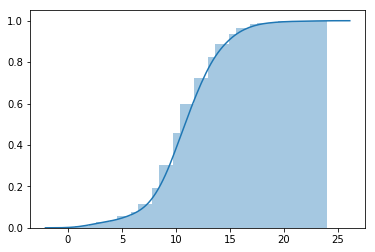

In [76]:
sns.distplot([len(x) for x in cheeses.get_docs().values()],
             hist_kws=dict(cumulative=True),
             kde_kws=dict(cumulative=True))


# Qualitative validation
We need some metrics to describe cheeses closeness

### Build cosine similarity matrix and apply hierarchical clustering to features extracted with TfidfVectorizer


(1829, 1829)
836
836


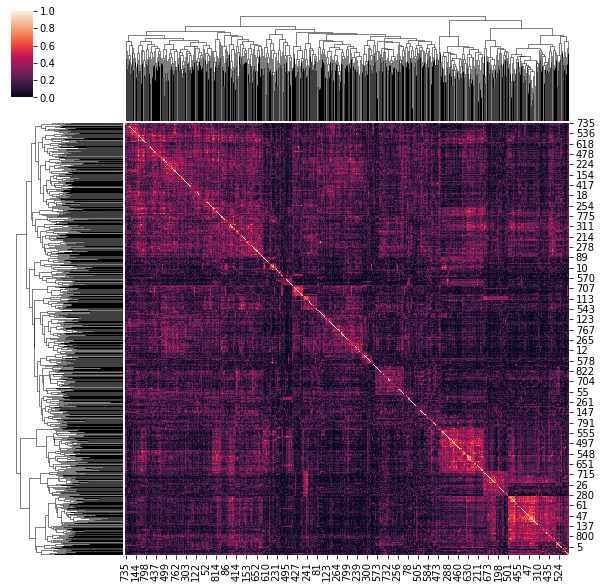

In [120]:
# Set up the matplotlib figure
# f, ax = plt.subplots(figsize=(11, 9))
similiarity_matrix, cosine, mean_sim_vec, filtered_indexes, fltrd_docs = cheeses.get_cosine_similarity_matrix(mean_similarity_thresh=0.2,min_description_len=12)
clg = sns.clustermap(similiarity_matrix)

## Defining close and far in chesse space
We're gonna set arbitrary thresholds at the 5th and 95th percentiles to define close and far

(1829, 1829)
836
836
really close cheeses have cosine similarity less than 0.34
really far apart cheeses have cosine similarity greater than 0.05


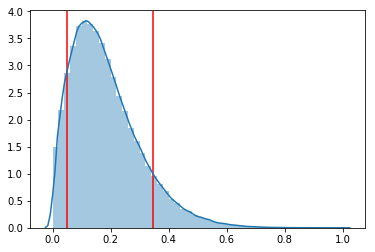

In [154]:
similiarity_matrix, _, _, _, _ = cheeses.get_cosine_similarity_matrix(feature_extractor='TfidfVectorizer',mean_similarity_thresh=0.2,min_description_len=12)
vec = similiarity_matrix.flatten()
index = np.argwhere(vec>=1)
y = np.delete(vec, index)
hplot = sns.distplot(y)
close_thresh = np.percentile(y, 90, axis=0)
far_thresh = np.percentile(y, 10, axis=0)
plt.vlines(close_thresh, ymin=0, ymax=4,colors='r')
plt.vlines(far_thresh, ymin=0, ymax=4,colors='r')
print("really close cheeses have cosine similarity less than {:.2f}".format(close_thresh))
print("really far apart cheeses have cosine similarity greater than {:.2f}".format(far_thresh))


In [ ]:
# pick a random cheese index from the filtered list filtered_indexes


In [196]:
cheese_idx = random.choice(filtered_indexes) #random.randint(0,similiarity_matrix.shape[0]-1)
# get the cheese
cheese = cheeses.raw_df.iloc[cheese_idx]
fltrd_idx = np.argwhere(np.array(filtered_indexes)==cheese_idx)
# get all the similarities with other cheeses
sim_to_cheese = similiarity_matrix[fltrd_idx,:].flatten()
# find closest cheese
closest_cheese = cheeses.raw_df.iloc[filtered_indexes[np.argsort(sim_to_cheese)[-2]]]
furthest_cheese = cheeses.raw_df.iloc[filtered_indexes[np.argsort(sim_to_cheese)[0]]]
os.system('open -a "Google Chrome" https://www.cheese.com/{}/'.format(cheese['name']))
os.system('open -a "Google Chrome" https://www.cheese.com/{}/'.format(closest_cheese['name']))
os.system('open -a "Google Chrome" https://www.cheese.com/{}/'.format(furthest_cheese['name']))
# print(sim_to_cheese[681])
# print(sim_to_cheese[fltrd_dx])
# sns.distplot(sim_to_cheese)
# print()

0

# Dimensionality reduction on cheeses features


In [81]:
cheeses.raw_df.loc[clg.dendrogram_row.reordered_ind[:]]

,name,aroma,colour,country_of_origin,family,flavour,ingredients,producers,region,rind,texture,type,vegetarian,synonyms,fat_content,alternative_spellings,calcium_content,fat_content_(in_dry_matter)
407,chelsea-blue,"nutty, sweet",NaN,australia,blue,"nutty, salty, sweet",NaN,boatshed cheese,"mornington peninsula, melbourne",NaN,crumbly,artisan,yes,NaN,NaN,NaN,NaN,NaN
406,cheese-curds,fresh,white,"canada, india and united states",cheddar,"mild, milky, salty",pasteurized or unpasteurized cow's milk,"fromagerie st-fidèle, la fromagerie boivin, ti...",NaN,natural,"firm, springy and supple","fresh firm, whey",NaN,"squeaky cheese, cheeseballs, paneer, curd, boi...",NaN,NaN,NaN,NaN
755,great-lakes-cheshire,NaN,straw,united states,NaN,full-flavored,unpasteurized cow's milk,zingerman's creamery,"ann arbor, michigan",natural,crumbly and supple,"hard, artisan",no,NaN,NaN,NaN,NaN,NaN
169,bermuda-triangle,"earthy, fresh, spicy",white,united states,brie,"earthy, piquant, spicy, tangy",pasteurized goat's milk,cypress grove chevre,california,bloomy,"creamy, crumbly, dense, firm and smooth","semi-soft, soft-ripened",yes,NaN,NaN,NaN,NaN,NaN
1026,manteca,"floral, fruity",pale yellow,italy,NaN,buttery,pasteurized cow's milk,casa madaio,basilicata,natural,"dense, elastic and stringy","semi-soft, artisan",no,"butirro , burrino, burriello",NaN,NaN,NaN,NaN
825,innes-brick,"fresh, lactic",white,"england, great britain and united kingdom",NaN,"mild, milky, nutty",unpasteurized goat's milk,highfields farm dairy,staffordshire,mold ripened,creamy and dense,"semi-soft, artisan",no,NaN,NaN,NaN,NaN,NaN
1401,queso-fresco-adobera,fresh,ivory,mexico,cottage,"mild, salty, spicy",pasteurized cow's milk,quesos navarro,NaN,natural,"crumbly, firm and grainy",fresh soft,NaN,queso adobera,NaN,NaN,NaN,NaN
1637,sun-dried-tomato-and-basil-cashew-cheese,"herbal, nutty",white,canada,NaN,"creamy, full-flavored, herbaceous, nutty, tangy",NaN,zengarry vegetarian cuisine,ontario,NaN,creamy,"soft, artisan",yes,NaN,NaN,NaN,NaN,NaN
89,asher-blue,"earthy, rich, strong",straw,united states,blue,"grassy, milky, mushroomy, salty, sweet, tangy",unpasteurized cow's milk,sweet grass dairy,georgia,natural,creamy and crumbly,"semi-soft, blue-veined",yes,NaN,NaN,NaN,NaN,NaN
181,bijou,"fresh, yeasty",NaN,united states,NaN,"sharp, sweet, tangy, yeasty",pasteurized goat's milk,vermont creamery,"websterville, vt",mold ripened,creamy and smooth,"semi-soft, artisan",NaN,NaN,11%,NaN,NaN,NaN


# Build Similarity Matrix and obtain Clusters using CountVectorizer

0

In [70]:
similiarity_matrix.shape

(1829, 1829)

(1829, 1829)
836
836
(1829, 1829)
1667
1667


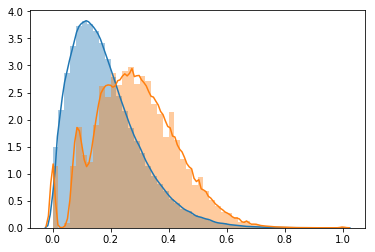

In [99]:
# plt.subplot(1, 2, 1)
similiarity_matrix, _, _, _ = cheeses.get_cosine_similarity_matrix(feature_extractor='TfidfVectorizer',mean_similarity_thresh=0.2,min_description_len=12)
vec = similiarity_matrix.flatten()
index = np.argwhere(vec>=1)
y = np.delete(vec, index)
sns.distplot(y)
similiarity_matrix, _, _, _ = cheeses.get_cosine_similarity_matrix(feature_extractor='CountVectorizer',mean_similarity_thresh=0.2,min_description_len=12)
vec = similiarity_matrix.flatten()
index = np.argwhere(vec>=1)
y = np.delete(vec, index)
sns.distplot(y,norm_hist=False)

(1829, 1829)
1777
1777


AttributeError: 'tuple' object has no attribute 'flatten'

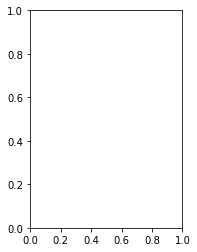

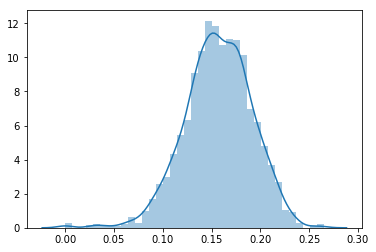

In [104]:
mean_vec = np.mean(cheeses.get_cosine_similarity_matrix(),axis=0)
sns.distplot(mean_vec)

## let's  get rid of the cheeses that have an average cosine_similarity less than 0.1

In [126]:
friendly_cheeses_indexes = np.argwhere(mean_vec>=.1)
cheeses.raw_df.loc[friendly_cheeses_indexes.flatten()]



,name,aroma,colour,country_of_origin,family,flavour,ingredients,producers,region,rind,texture,type,vegetarian,synonyms,fat_content,alternative_spellings,calcium_content,fat_content_(in_dry_matter)
0,Kabritt,"earthy, rich",ivory,canada,tomme,"buttery, salty, tangy",pasteurized goat's milk,the farm house natural cheeses,british columbia,natural,buttery,"hard, artisan",no,NaN,NaN,NaN,NaN,NaN
1,abbaye-de-belloc,lanoline,yellow,france,NaN,burnt caramel,unpasteurized cow's and sheep's milk,abbaye de notre-dame de belloc,pays basque,natural,"creamy, dense and firm","semi-hard, artisan",yes,abbaye notre-dame de belloc,NaN,NaN,NaN,NaN
3,abbaye-de-citeaux,"barnyardy, earthy",white,france,NaN,"acidic, milky, smooth",unpasteurized cow's milk,frères frédéric and joel,burgundy,washed,"creamy, dense and smooth","semi-soft, artisan, brined",no,NaN,NaN,NaN,NaN,NaN
4,abbaye-de-timadeuc,NaN,pale yellow,france,NaN,NaN,pasteurized cow's milk,NaN,province of brittany,washed,soft,semi-hard,no,NaN,NaN,NaN,NaN,NaN
5,abbaye-du-mont-des-cats,floral,pale yellow,france,NaN,"milky, salty",pasteurized cow's milk,abbaye du mont des cats,nord-pas-de-calais,washed,smooth and supple,"semi-soft, artisan, brined",no,NaN,50%,NaN,NaN,NaN
6,abbots-gold,aromatic,pale yellow,"england, great britain and united kingdom",cheddar,"mild, sweet, tangy",pasteurized cow's milk,wensleydale creamery,north yorkshire,natural,"creamy, crumbly, dense and semi firm",semi-hard,yes,"english cheddar with caramelized onions, caram...",NaN,NaN,NaN,NaN
7,abertam,NaN,pale yellow,czech republic,NaN,"acidic, strong, tangy",sheep's milk,NaN,karlovy vary,natural,firm,"hard, artisan",no,NaN,45%,NaN,NaN,NaN
8,abondance,nutty,pale yellow,france,tomme,"acidic, buttery, fruity, sweet",unpasteurized cow's milk,NaN,"haute-savoie, abondance",natural,"creamy, open and supple","semi-hard, artisan",no,NaN,48%,tomme d'abondance,NaN,NaN
9,acapella,"fresh, herbal",NaN,united states,NaN,buttery,goat's milk,andante dairy,california,NaN,NaN,"soft, soft-ripened",no,NaN,NaN,NaN,NaN,NaN
10,accasciato,"aromatic, fresh",pale yellow,italy,NaN,sweet,buffalo's and cow's milk,casa madaio,campania,natural,firm,semi-hard,no,NaN,NaN,NaN,NaN,NaN


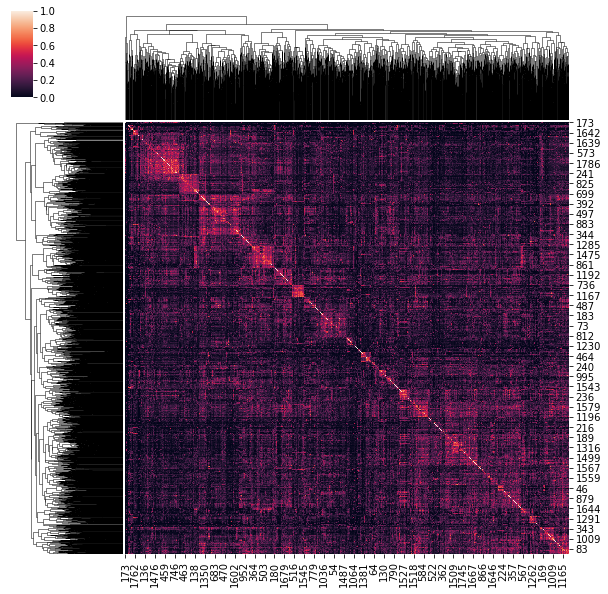

In [41]:
g = sns.clustermap(cosine)

## Pick random cheese and suggest ten closest 

In [49]:
sim_matrix = cheeses.get_cosine_similarity_matrix()

In [68]:
cheese_index = random.randint(0,len(cheeses.raw_df)-1)
cheeses.raw_df.iloc[cheese_index]

name                                             pigouille
aroma                                            barnyardy
colour                                               ivory
country_of_origin                                   france
family                                                 NaN
flavour                        acidic, salty, sweet, tangy
ingredients                     unpasteurized sheep's milk
producers                                              NaN
region                                           charentes
rind                                          mold ripened
texture                         creamy, crumbly and grainy
type                                         soft, artisan
vegetarian                                             NaN
synonyms                                               NaN
fat_content                                            NaN
alternative_spellings              pigouille des charentes
calcium_content                                        N

In [69]:
for index in np.argsort(sim_matrix[cheese_index])[-4:-1]:
    print(cheeses.raw_df.iloc[index])

name                                                                cabrales
aroma                                                                 strong
colour                                                                  blue
country_of_origin                                                      spain
family                                                                  blue
flavour                                                 acidic, salty, sharp
ingredients                     unpasteurized cow's, goat's and sheep's milk
producers                                                                NaN
region                                                              asturias
rind                                                            mold ripened
texture                                                      creamy and firm
type                                         semi-hard, artisan, blue-veined
vegetarian                                                                no

In [ ]:
import numpy as np
from sklearn import manifold
model = manifold.TSNE(metric="precomputed",n_components=3)
Y = model.fit_transform(cheeses.get_similarity_matrix())


In [45]:
len(cheeses.raw_df)

1829

In [71]:
cosine.sshape

NameError: name 'cosine' is not defined

In [64]:
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
# nltk.download('punkt')

In [85]:
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer



tokenizer = RegexpTokenizer(r'\w+')
stopWords = set(stopwords.words('english'))
print(simple_tokenizer(docs[1]))
print(docs[1])

['hard', 'artisan', 'acidic', 'mellow', 'unpasteurized', 'cow', 'natural']
hard, artisan,acidic, mellow,unpasteurized cow's milk,natural


In [86]:
a = simple_tokenizer(docs[1])
a

['hard', 'artisan', 'acidic', 'mellow', 'unpasteurized', 'cow', 'natural']

In [87]:
from sklearn.feature_extraction.text import TfidfVectorizer

def dummy_fun(doc):
    return doc

tfidf = TfidfVectorizer(
    analyzer='word',
    tokenizer=simple_tokenizer,
    preprocessor=dummy_fun,
    token_pattern=None)  


0.0

In [12]:
list(docs.values())

[['earthy',
  'rich',
  'buttery',
  'salty',
  'tangy',
  'tomme',
  'natural',
  'buttery',
  'hard',
  'artisan',
  'pasteurized',
  'goat'],
 ['lanoline',
  'burnt',
  'caramel',
  'natural',
  'creamy',
  'dense',
  'firm',
  'semi-hard',
  'artisan',
  'unpasteurized',
  'cow',
  'sheep'],
 ['aromatic', 'washed', 'elastic', 'semi-hard', 'cow'],
 ['barnyardy',
  'earthy',
  'acidic',
  'smooth',
  'washed',
  'creamy',
  'dense',
  'smooth',
  'semi-soft',
  'artisan',
  'brined',
  'unpasteurized',
  'cow'],
 ['washed', 'soft', 'semi-hard', 'pasteurized', 'cow'],
 ['floral',
  'salty',
  'washed',
  'smooth',
  'supple',
  'semi-soft',
  'artisan',
  'brined',
  'pasteurized',
  'cow'],
 ['aromatic',
  'mild',
  'sweet',
  'tangy',
  'cheddar',
  'natural',
  'creamy',
  'crumbly',
  'dense',
  'semi',
  'firm',
  'semi-hard',
  'pasteurized',
  'cow'],
 ['acidic', 'strong', 'tangy', 'natural', 'firm', 'hard', 'artisan', 'sheep'],
 ['nutty',
  'acidic',
  'buttery',
  'fruity',
 

In [52]:
set(cheeses.raw_df['family'])

{nan,
 'cottage',
 'parmesan',
 'cheddar',
 'raclette',
 'blue',
 'tomme',
 'pecorino',
 'feta',
 'camembert',
 'italian cheese',
 'saint-paulin',
 'gorgonzola',
 'gruyere',
 'caciotta',
 'swiss cheese',
 'monterey jack',
 'havarti',
 'pasta filata',
 'gouda',
 'brie',
 'mozzarella',
 'cornish'}

In [53]:
cheeses.raw_df[cheeses.raw_df['family']=='gouda']

,name,aroma,colour,country_of_origin,family,flavour,ingredients,producers,region,rind,texture,type,vegetarian,synonyms,fat_content,alternative_spellings,calcium_content,fat_content_(in_dry_matter)
28,aged-gouda,"rich, ripe",yellow,netherlands,gouda,"burnt caramel, full-flavored","pasteurized or unpasteurized cow's, goat's or ...",NaN,"south holland, gouda",waxed,"brittle, crumbly, crystalline and flaky","hard, artisan, brined, processed",no,"jong belegen gouda, belegen gouda, extra beleg...",31 g/100g,NaN,958 mg/100g,76%
62,amul-gouda,mild,yellow,india,gouda,"fruity, sweet",pasteurized cow's milk,gujarat cooperative milk marketing federation ...,gujarat,plastic,"compact, dense, firm and springy",semi-hard,yes,NaN,46%,NaN,492 mg/100g,NaN
150,beemster-aged,rich,yellow,holland and netherlands,gouda,"full-flavored, smooth, spicy, strong",pasteurized cow's milk,"beemster cheese, cono kaasmakers / beemster",NaN,natural,"crystalline, firm and smooth",hard,no,beemster old,NaN,NaN,NaN,NaN
151,beemster-classic,"rich, strong",yellow,holland and netherlands,gouda,"burnt caramel, salty, sharp, sweet",pasteurized cow's milk,"beemster cheese, cono kaasmakers / beemster",NaN,natural,"creamy, firm and smooth",semi-hard,no,NaN,NaN,NaN,NaN,NaN
152,beemster-extra-aged,aromatic,golden yellow,holland and netherlands,gouda,"butterscotch, nutty",pasteurized cow's milk,"beemster cheese, cono kaasmakers / beemster",NaN,natural,"brittle, crumbly and grainy",hard,no,"beemster extra old, beemster x-o",NaN,NaN,NaN,NaN
153,beemster-graskaas,rich,yellow,holland and netherlands,gouda,full-flavored,pasteurized cow's milk,"beemster cheese, cono kaasmakers / beemster",NaN,natural,"creamy, open and smooth",semi-hard,no,NaN,NaN,NaN,NaN,NaN
188,blarney-castle,NaN,golden yellow,ireland,gouda,"smooth, tangy",pasteurized cow's milk,kerrygold,blarney,natural,creamy,semi-soft,no,NaN,NaN,NaN,NaN,NaN
206,blue-ledge-la-luna,grassy,white,united states,gouda,"creamy, milky, tangy",unpasteurized goat's milk,blue ledge,vermont,waxed,firm and smooth,"semi-hard, artisan",no,la luna,NaN,NaN,NaN,NaN
216,boeren-leidse-met-sleutels,"aromatic, rich",yellow,holland and netherlands,gouda,"fruity, spicy",unpasteurized cow's milk,vereniging van boeren-leidse kaasmakers,leiden,waxed,crumbly and firm,"hard, artisan",no,"farmers leiden, leidse kaas, leyden cheese, bo...",30-40%,NaN,NaN,NaN
259,brimstone,spicy,pale yellow,united states,gouda,"smooth, spicy",pasteurized cow's milk,heartland creamery,missouri,rindless,crumbly,"semi-hard, artisan",yes,NaN,NaN,NaN,NaN,NaN


In [ ]:
# f, ax = plt.subplots(figsize=(11, 9))
# plt.plot3(Y[:,0],Y[:,1],Y[:,2],'.')

fig = plt.figure(figsize=(11, 9))
ax = fig.add_subplot(111, projection='3d')

n = 100

# For each set of style and range settings, plot n random points in the box
# defined by x in [23, 32], y in [0, 100], z in [zlow, zhigh].

ax.scatter(Y[:,0],Y[:,1],Y[:,2],)

ax.set_xlabel('1st Dimension')
ax.set_ylabel('2nd Dimension')
ax.set_zlabel('3rd Dimension')

 # set axes range
plt.xlim(-100, 100)
plt.ylim(-100, 100)
ax.set_zlim(-100,100)

In [111]:
test = cheeses.raw_df['name'].loc[[3,4]]


In [112]:
test

3     abbaye-de-citeaux
4    abbaye-de-timadeuc
Name: name, dtype: object

In [135]:
a = np.random.rand(5,5)
a

array([[ 0.419456  ,  0.53129055,  0.23719338,  0.76152535,  0.22111651],
       [ 0.31535546,  0.26175308,  0.11453971,  0.25756922,  0.21424348],
       [ 0.66630396,  0.73553731,  0.91972619,  0.93042985,  0.47380027],
       [ 0.0976831 ,  0.13448071,  0.68420668,  0.71527676,  0.09547378],
       [ 0.4710143 ,  0.26338198,  0.53317701,  0.99940894,  0.19280961]])

In [139]:
a[[1,3],:][:,[1,3]]

array([[ 0.26175308,  0.25756922],
       [ 0.13448071,  0.71527676]])

In [146]:
cheeses.docs

{'Kabritt': ['earthy',
  'rich',
  'buttery',
  'salty',
  'tangy',
  'natural',
  'buttery',
  'hard',
  'artisan',
  'pasteurized',
  'goat'],
 'abbaye-de-belloc': ['lanoline',
  'burnt',
  'caramel',
  'natural',
  'creamy',
  'dense',
  'firm',
  'semi-hard',
  'artisan',
  'unpasteurized',
  'cow',
  'sheep'],
 'abbaye-de-belval': ['aromatic', 'washed', 'elastic', 'semi-hard', 'cow'],
 'abbaye-de-citeaux': ['barnyardy',
  'earthy',
  'acidic',
  'smooth',
  'washed',
  'creamy',
  'dense',
  'smooth',
  'semi-soft',
  'artisan',
  'brined',
  'unpasteurized',
  'cow'],
 'abbaye-de-timadeuc': ['washed', 'soft', 'semi-hard', 'pasteurized', 'cow'],
 'abbaye-du-mont-des-cats': ['floral',
  'salty',
  'washed',
  'smooth',
  'supple',
  'semi-soft',
  'artisan',
  'brined',
  'pasteurized',
  'cow'],
 'abbots-gold': ['aromatic',
  'mild',
  'sweet',
  'tangy',
  'natural',
  'creamy',
  'crumbly',
  'dense',
  'semi',
  'firm',
  'semi-hard',
  'pasteurized',
  'cow'],
 'abertam': ['ac

In [38]:
a = [1,2]

In [39]:
b = [1,3]

In [61]:
n_descriptors = np.array([len(x) for x in list(cheeses.docs.values())])
detailed_cheeses_indexes = np.argwhere(n_descriptors>=7).flatten()

In [62]:
detailed_cheeses_indexes

array([   0,    1,    3, ..., 1826, 1827, 1828])

array([[3]])